### In-Class Two-Layer Base

In [1]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    

In [2]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # backpropagation
        grad1 = np.zeros(W1.shape)
        grad2 = np.zeros(W2.shape)
        
        # for each instance's activations 
        for (a1,a2,a3,y) in zip(A1.T,A2.T,A3.T,Y_enc.T):
            dJ_dz2 = -2*(y - a3)*a3*(1-a3)
            dJ_dz1 = dJ_dz2 @ W2 @ np.diag(a2*(1-a2))
                         
            grad2 += dJ_dz2[:,np.newaxis]  @ a2[np.newaxis,:]
            grad1 += dJ_dz1[1:,np.newaxis] @ a1[np.newaxis,:] 
            # don't incorporate bias term in the z1 gradient 
            # (its added in a2 from another layer)
            

        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self

In [3]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

### Custom MLP Implementation

In [304]:
class MultilayerPerceptron(TwoLayerPerceptronVectorized):
    def __init__(self, nlayers=3, phi='sigmoid', cost='quadratic', **kwds):
        
        self.nlayers = nlayers
        self.phi_func = phi
        self.cost_func = cost
        self.alpha_ = 1.6732632423543772848170429916717
        self.lambda_ = 1.0507009873554804934193349852946
        
        super().__init__(**kwds)
        
        
    @staticmethod
    def _L2_reg(lambda_, weights):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        sum_ = 0
        for w in weights:
            sum_ += np.mean(w[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(sum_)
    
    @staticmethod
    def _linear(x):
        return x
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _selu(Z):
        return  Z * expit(Z)    
    
    def _initialize_weights(self):
        
        _weights = []
        for i in range(self.nlayers-1):
            """Initialize weights with small random numbers."""
            if i == 0:              
                W1 = np.random.randn(self.n_hidden, self.n_features_ + 1)
                W1[:,1:] = W1[:,1:]/np.sqrt(self.n_features_+1) # don't saturate the neuron
                W1[:,:1] = 0 # common practice to start with zero bias
                _weights.append(W1)
                continue
            W1 = np.random.randn(self.n_hidden, _weights[i-1].shape[0] + 1)
            W1[:,1:] = W1[:,1:]/np.sqrt(_weights[i-1].shape[0]+1) # don't saturate the neuron
            W1[:,:1] = 0 # common practice to start with zero bias
            _weights.append(W1)
            
    
        '''initialize weights for output layer'''
        W2 = np.random.randn(self.n_output_, self.n_hidden + 1)
        W2[:,1:] = W2[:,1:]/np.sqrt(self.n_hidden + 1) # don't saturate the neuron
        W2[:,:1] = 0 # common practice to start with zero bias
        _weights.append(W2)
        
        return _weights

        
    def _feedforward(self, X, weights):
        
        _layers = [] # list of A matrices
        
        '''set phi function'''
        if self.phi_func == 'sigmoid':
            _phi = self._sigmoid
        elif self.phi_func == 'linear':
            _phi = self._linear
        elif self.phi_func == 'relu':
            _phi = self._relu
        elif self.phi_func == 'selu':
            _phi = self._selu
            
        
        for i in range(self.nlayers+1):
            #compute first layer
            if i == 0:
                A1 = self._add_bias_unit(X.T, how='row')
                _layers.append(A1)
 
                continue
                
            #compute ith layer
            A_prev = _layers[i-1]
            W_prev = weights[i-1]
            
 
            Z_prev = W_prev @ A_prev

            A_i = _phi(Z_prev)
  
            
            #add bias, if layer isn't output layer
            if i < self.nlayers:
                A_i = self._add_bias_unit(A_i, how='row')
                
            #use sigmoid for output layer if using relu
            if self.phi_func == 'relu' and i == self.nlayers:
                A_i = self._sigmoid(Z_prev)

            #add layer to _layers
            _layers.append(A_i)
            
            
        return _layers
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]                
        self.weights = self._initialize_weights()
        
        self.grad_avgs = [np.zeros(self.epochs) for _ in range(len(self.weights))] 
        self.grad3 = np.zeros(self.epochs)
        self.grad1 = np.zeros(self.epochs)
        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            layers = self._feedforward(X_data, self.weights)
            cost = self._cost(layers[self.nlayers],Y_enc, self.weights)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grads = self._get_gradient(layers=layers, Y_enc=Y_enc, weights=self.weights)
                
            for k in range(len(grads)):
                self.grad_avgs[k][i] = np.mean(grads[k])
                
            self.grad3[i] = np.mean(grads[2])
            self.grad1[i] = np.mean(grads[0])
            #update weights and save avg gradients
            for j in range(len(self.weights)):
                self.weights[j] -= self.eta * grads[j]
            

        return self
    
    def predict(self, X):
        """Predict class labels"""
        layers= self._feedforward(X, self.weights)
        y_pred = np.argmax(layers[self.nlayers], axis=0)
        return y_pred
    
    def _cost(self, Af, Y_enc, weights):
        '''Get the objective function value'''
        
        if self.cost_func == 'quadratic':            
            cost = np.mean((Y_enc-Af)**2)
            L2_term = self._L2_reg(self.l2_C, weights)
            
        elif self.cost_func == 'cross_entropy':
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(Af)+(1-Y_enc)*np.log(1-Af))))
            L2_term = self._L2_reg(self.l2_C, weights)
            
        return cost + L2_term

    
    def _get_gradient(self, layers, Y_enc, weights):
        """ Compute gradient step using backpropagation for each layer
        """
        _V = []
        _grads = []
        
        '''calculate sensitivity at final layer'''
        #quadratic cost
        if self.cost_func == 'quadratic':
            Vf = -2 * (Y_enc-layers[self.nlayers])*layers[self.nlayers]*(1-layers[self.nlayers])
            
        #cross entropy cost   
        elif self.cost_func == 'cross_entropy':
            Vf = (layers[self.nlayers] - Y_enc) 
            
        #calculate gradient for wrt last layer
        grad_f = Vf @ layers[self.nlayers-1].T

        #regularize gradient that are not bias
        grad_f[:,1:] += weights[self.nlayers-1][:, 1:] * self.l2_C
        
        _V.append(Vf)
        _grads.append(grad_f)
        
        '''backpropagate through L-1 layers to calculate sensitivities''' 
        for i in range(self.nlayers-2,-1,-1):
   
            A_i = layers[i+1]  #A_i+1
            W_i = weights[i+1] #W_i+1
            V_i2 = _V[0]       #uses sensitivity of layer (i+1)
            
            if self.phi_func == 'relu':
                V_i = (W_i.T[1:,:] @ V_i2) 
                V_i[A_i[1:,:]<=0] = 0
          
            else:   
                #calculate sensitivity for layer i
                V_i = A_i[1:,:]*(1-A_i[1:,:])*(W_i.T[1:,:] @ V_i2)

            #insert sensitivity for layer i at front of list
            _V.insert(0,V_i)
            
            #calculate gradient for layer i
            grad_i = V_i @ layers[i].T
            
            #regularize weights that are not bias terms
            grad_i += weights[i]
            
            _grads.insert(0,grad_i)
        
        return _grads
    

### Testing 


In [5]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

ds = load_digits()
X = ds.data/16.0-0.5
y = ds.target

print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))

(1797, 64)
(1797,)
-0.5 0.5
[0 1 2 3 4 5 6 7 8 9]


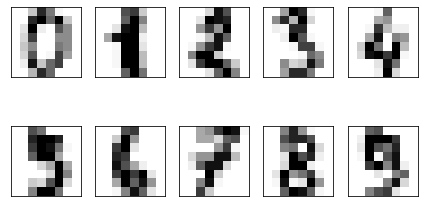

In [6]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1437, 64)
(1437,)
(360, 64)
(360,)


In [318]:
X_train

array([[-0.5   , -0.5   , -0.0625, ..., -0.1875, -0.5   , -0.5   ],
       [-0.5   , -0.5   ,  0.    , ..., -0.5   , -0.5   , -0.5   ],
       [-0.5   , -0.5   , -0.25  , ...,  0.25  , -0.4375, -0.5   ],
       ...,
       [-0.5   , -0.5   , -0.0625, ..., -0.5   , -0.5   , -0.5   ],
       [-0.5   , -0.5   , -0.1875, ...,  0.1875, -0.3125, -0.5   ],
       [-0.5   , -0.5   , -0.3125, ...,  0.    , -0.375 , -0.5   ]])

In [258]:
from sklearn.metrics import f1_score
params = dict(n_hidden=80, 
              C=0.1, # tradeoff L2 regularizer
              epochs=300, # iterations
              eta= 0.0001,  # learning rate
              random_state=1,
              nlayers=4,
              phi='selu',
              cost='cross_entropy',
              )


mlp = MultilayerPerceptron(**params)
mlp.fit(X_train, y_train, print_progress=True)
yhat = mlp.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test,yhat))
#print("Macro F1 Score:", f1_score(y_test,yhat, average='macro', labels=[1,2,3,4,5,6,7,8,9]))

Epoch: 1/300/Users/eli/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in log
Epoch: 300/300

Accuracy Score: 0.7944444444444444


In [152]:
np.unique(y_test)
np.unique(yhat)

array([0, 2, 4, 6, 7])

### Hyper-Parameter Tuning

In [284]:
base_params = dict( 
              C=0.1, # tradeoff L2 regularizer
              eta=0.001,  # learning rate
              random_state=1,
            )


phi_list = ['sigmoid','linear']
cost_list = ['quadratic','cross_entropy']
epochs_list = [200, 400, 500]
n_layers_list = [2,3,4,5]
n_neurons_list = [30,50,80]
etas = [0.001, 1e-5]



param_list = []
for epoch in epochs_list:
    for phi in phi_list:
        for cost in cost_list:
            for n_layer in n_layers_list:
                for n_neurons in n_neurons_list:
                    for eta in etas:
                        params = base_params.copy()
                        params['eta'] = eta
                        params['phi'] = phi
                        params['cost'] = cost
                        params['epochs'] = epoch
                        params['nlayers'] = n_layer
                        params['n_hidden'] = n_neurons
                        param_list.append(params)
print(len(param_list))


288


In [216]:
#evaluate model on each param combination
cost_param = []
for params in param_list[:50]:
    mlp = MultilayerPerceptron(**params)
    mlp.fit(X_train, y_train)
    yhat = mlp.predict(X_test)
    cost = accuracy_score(y_test,yhat)#f1_score(y_test, yhat, average='macro', labels=[1,2,3,4,5,6,7,8,9])
    cost_param.append((cost, params))
    print("Activation: {} | Objective Function: {} | N_layers: {} | N_hidden: {} | Eta: {} | Epochs: {} | F1_Score: {}".format(\
                                                                                                params['phi'],\
                                                                                                params['cost'],\
                                                                                                params['nlayers'],\
                                                                                                params['n_hidden'],\
                                                                                                params['eta'],\
                                                                                                params['epochs'],\
                                                                                                cost
                                                                                                ))
    
    
    
    

Activation: sigmoid | Objective Function: quadratic | N_layers: 2 | N_hidden: 30 | Eta: 0.001 | Epochs: 200 | F1_Score: 0.875
Activation: sigmoid | Objective Function: quadratic | N_layers: 2 | N_hidden: 30 | Eta: 1e-05 | Epochs: 200 | F1_Score: 0.16666666666666666
Activation: sigmoid | Objective Function: quadratic | N_layers: 2 | N_hidden: 50 | Eta: 0.001 | Epochs: 200 | F1_Score: 0.8972222222222223
Activation: sigmoid | Objective Function: quadratic | N_layers: 2 | N_hidden: 50 | Eta: 1e-05 | Epochs: 200 | F1_Score: 0.2111111111111111
Activation: sigmoid | Objective Function: quadratic | N_layers: 2 | N_hidden: 80 | Eta: 0.001 | Epochs: 200 | F1_Score: 0.9027777777777778
Activation: sigmoid | Objective Function: quadratic | N_layers: 2 | N_hidden: 80 | Eta: 1e-05 | Epochs: 200 | F1_Score: 0.2222222222222222
Activation: sigmoid | Objective Function: quadratic | N_layers: 3 | N_hidden: 30 | Eta: 0.001 | Epochs: 200 | F1_Score: 0.33611111111111114
Activation: sigmoid | Objective Functi

/Users/eli/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: overflow encountered in matmul
/Users/eli/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in square
/Users/eli/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:180: RuntimeWarning: invalid value encountered in matmul
/Users/eli/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/Users/eli/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in matmul


Activation: linear | Objective Function: quadratic | N_layers: 2 | N_hidden: 30 | Eta: 1e-05 | Epochs: 200 | F1_Score: 0.08333333333333333


#### Top Performing Parameters



In [193]:

cost_param.sort(key=lambda x: x[0], reverse=True)

for i,key in enumerate(cost_param[:6]):
    print("{}. Activation: {} | Objective Function: {} | N_layers: {} | N_hidden: {} | Epochs: {} | F1_Score: {}".format(\
                                                                                                i+1,
                                                                                                key[1]['phi'],\
                                                                                                key[1]['cost'],\
                                                                                                key[1]['nlayers'],\
                                                                                                key[1]['n_hidden'],\
                                                                                                key[1]['epochs'],\
                                                                                                key[0]
                                                                                                ))

1. Activation: sigmoid | Objective Function: cross_entropy | N_layers: 3 | N_hidden: 50 | Epochs: 200 | F1_Score: 0.930038320711059
2. Activation: sigmoid | Objective Function: cross_entropy | N_layers: 3 | N_hidden: 80 | Epochs: 200 | F1_Score: 0.7526917195662501
3. Activation: sigmoid | Objective Function: cross_entropy | N_layers: 4 | N_hidden: 30 | Epochs: 200 | F1_Score: 0.32670738588661125
4. Activation: sigmoid | Objective Function: cross_entropy | N_layers: 4 | N_hidden: 50 | Epochs: 200 | F1_Score: 0.033905182142087306
5. Activation: sigmoid | Objective Function: cross_entropy | N_layers: 4 | N_hidden: 80 | Epochs: 200 | F1_Score: 0.014430014430014432
6. Activation: sigmoid | Objective Function: cross_entropy | N_layers: 5 | N_hidden: 30 | Epochs: 200 | F1_Score: 0.014430014430014432


### 

## Visualizing Gradients

In [317]:
params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=300, # iterations
              eta= 0.001,  # learning rate
              random_state=1,
              nlayers=3,
              phi='sigmoid',
              cost='cross_entropy',
              )


mlp = MultilayerPerceptron(**params)
mlp.fit(X_train, y_train, print_progress=True)
yhat = mlp.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test,yhat))

Epoch: 300/300

Accuracy Score: 0.9416666666666667


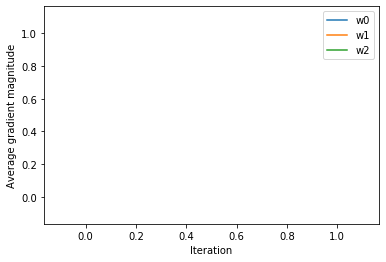

In [316]:
ax = plt.subplot(1,1,1)
for i,grad in enumerate(mlp.grad_avgs):
    w = 'w{}'.format(i)
    plt.plot(abs(grad[10:]), label=w)
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()